---
title:  "keras를 이용한 시계열 분석 LSTM 활용"
excerpt: "Keras를 사용한 시계열 분석"

categories:
  - Machine-Learning
tags:
  - Keras
  - Time Series Analysis
  - LSTM  
  - Advanced Keras
last_modified_at: 2020-04-01T16:13:00-05:00
---

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Keras를 활용한 시계열 분석

## 케라스 고급사용법
- recurrent dropout : 순환층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드랍아웃기능
- stacking recurrent layer : 네트워크의 표현 능력을 증가시킴
- bidirectional recurrent layer : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킨다.

### 기온예측 데이터 불러오기  
 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다. 이 데이터를 사용하여 마지막 데이터 포인트에서부터 24시간 이후의 온도를 예측하겠습니다.  
 이 데이터셋에는 수년간에 걸쳐 (기온, 기압, 습도, 풍향 등과 같은) 14개의 관측치가 10분마다 기록되어 있습니다. 원본 데이터는 2003년부터 기록되어 있지만 이 예제에서는 2009~2016년 사이의 데이터만 사용합니다. 이 데이터셋은 시계열 수치 데이터를 다루는 법을 익히는 데 안성맞춤입니다. 최근 데이터(몇 일치 데이터 포인트)를 입력으로 사용해 모델을 만들고 24시간 이후의 기온을 예측하겠습니다.

In [2]:
import os

data_dir = 'D:/★2020_ML_DL_Project/Alchemy/dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
fname

'D:/★2020_ML_DL_Project/Alchemy/dataset/jena_climate\\jena_climate_2009_2016.csv'

In [4]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
print(len(header))

15


In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1)) #  len(header) - 1 = 14임. 
print("float_data_shape {}".format(float_data.shape))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # Date Time 은 제외하고, 값에 넣고 있음.
    float_data[i, :] = values

float_data_shape (420551, 14)


In [7]:
print("ndim:{}".format(float_data.ndim),"   shape:{}".format(float_data.shape))

ndim:2    shape:(420551, 14)


In [8]:
np.set_printoptions(precision=6)
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [9]:
lines[0] ## 의도적으로 Datatime 은 float_data 셋에서, 컬럼화되지 않았음을 알 수 있다.

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

예를 들어 다음은 시간에 따른 기온(섭씨) 그래프입니다:

In [10]:
from matplotlib import pyplot as plt

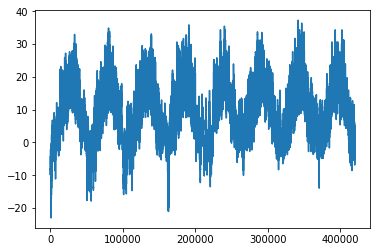

In [11]:
temp = float_data[:, 1]  # 온도(섭씨) "T (degC)"
plt.plot(range(len(temp)), temp)
plt.show()

이 그래프에서 온도에 주기성이 있다는 것을 잘 볼 수 있습니다.

다음은 기간을 좁혀서 처음 10일간의 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다:

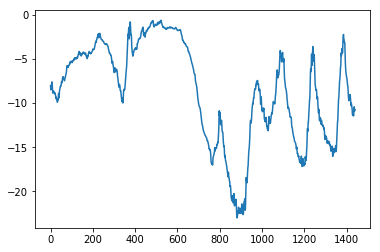

In [12]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 필자는 pandas 가 익숙해서 바꾼다. 

In [13]:
header_pd = list(map(lambda x : x.replace('"','').replace(' ','').upper(),header[1:]) )
print(header_pd)

['P(MBAR)', 'T(DEGC)', 'TPOT(K)', 'TDEW(DEGC)', 'RH(%)', 'VPMAX(MBAR)', 'VPACT(MBAR)', 'VPDEF(MBAR)', 'SH(G/KG)', 'H2OC(MMOL/MOL)', 'RHO(G/M**3)', 'WV(M/S)', 'MAX.WV(M/S)', 'WD(DEG)']


In [14]:
import pandas as pd
float_df = pd.DataFrame(float_data,columns = header_pd)
print(float_df.shape,"float_data.shape:{}".format(float_data.shape))

(420551, 14) float_data.shape:(420551, 14)


In [15]:
float_df.head(3)

,P(MBAR),T(DEGC),TPOT(K),TDEW(DEGC),RH(%),VPMAX(MBAR),VPACT(MBAR),VPDEF(MBAR),SH(G/KG),H2OC(MMOL/MOL),RHO(G/M**3),WV(M/S),MAX.WV(M/S),WD(DEG)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


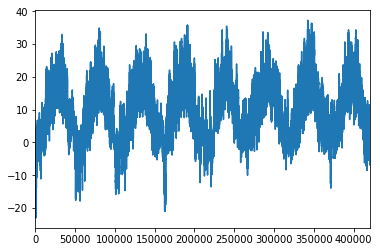

In [16]:
float_df["T(DEGC)"].plot(kind='line') ## 이렇게 해도 위에와 똑같다.

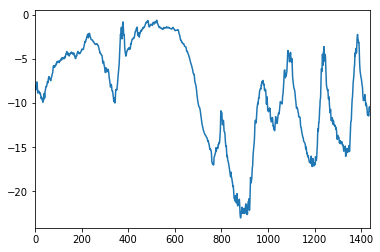

In [17]:
float_df["T(DEGC)"].iloc[:1440].plot(kind='line') ##  기간을 좁혀서 다시 표현한다.

In [18]:
print(60*24) ## 1일치를 분으로 환산한 값
## 본 예제에서는 10분다 1개의 row 이므로, 
print(60*24/10) ## 즉 144 row (행) 이 1일치이고, 6row(행) 이 1 hour 이다.

1440
144.0


## Preparing the data & 1일후 하루 후 값을 예측해보기

* `lookback = 1440` : 1440 을 넣으면, 10일 전 데이터로 돌아간다는 의미로 설정하는 것
* `steps = 6` : 6이란 값을 넣으면, 한 시간마다 데이터 포인트 하나를 샘플링한다는 뜻.
* `delay = 144` : 144 값을 넣으면, 24시간이 지난 데이터가 타깃이 된다는 뜻

#### 데이터 전처리
각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다.  
처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산한다.

In [19]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다. 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [20]:
np.random.randint(0,10,3) ## 함수 확인용으로 test

array([1, 7, 1])

In [21]:
np.arange(10,20) ## 함수 확인용으로 test

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [22]:
for i in range(1,10,2): ## 함수 확인용으로 test
    print(i)

1
3
5
7
9


In [23]:
def generator_test(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1 ## 추출한 타임의 max 범위를 지정하지 않으면, 전체데이터에서, delay 부분을 빼고, -1 한 부분까지가 max_index로 지정된다.
                                          ## 즉 validatin set 이 없어진다는 의미로, 이해하면 된다.
    i = min_index + lookback # 데이터 시작 time_stamp 에서, lookback 값을 더한다. 뒤에, lookback 만큼 역주행해서, 데이터를 긁어오니, 그만큼의 용량을 확보하기 위해 시작점을 lookback만큼더함
    print("i(min_index + lookback)의미 :{}".format(i))
    while 1: # 무조건 while 문을 실행하기 위함
        print("While loop start")
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)## 1440 ~ 200000 사이에서, 배치128 만큼의 index 를 무작위로 뽑는다.
        else:
            if i + batch_size >= max_index: # 데이터 시작 time_stamp 가 max_index 보다 크다면,
                i = min_index + lookback # 데이터 시작 time_stamp 에서, lookback 값을 더한다. 'pass' 처리해도 될듯 
            print("i {}".format(i))
            ## i 는 결국 시작 time_stamp 가 된다.
            rows = np.arange(i, min(i + batch_size, max_index)) # arange 객체생성. min()으로 인해, 배치 128 또는 max_index 까지만큼의 갯수를 뽑아낸다.
            i += len(rows) # shuffle 이 아닐경우이니, 다음 yield 에서, 다음 값을 추출하기 위해 처리해주는 구문

        samples = np.zeros((len(rows), ## 배치  dimension
                           lookback // step, ## 나누기의 몫 을 return 함. "lookback // step" 은 보고자 하는 값들을 시간 단위로 쪼개갰다는 의미이다. step=6 이 결국 10분 * 6 = 1시간
                           data.shape[-1])) # 1row의 n차원 벡터 feature. data의 마지막 차원을 불러온다. 3d tensor 로 보여줌
        print("samples.shape:{}".format(samples.shape))
        targets = np.zeros((len(rows),))
        
        print("data.shape:{}".format(data.shape))
        for j, row in enumerate(rows): # 배치수 128 만큼 반복한다.
            indices = range(rows[j] - lookback, rows[j], step) # rows[j]에 해당하는 index 값-과거 10일전 => 즉 해당 index 데이터의 10일전 과거 ~ 해당 index 까지의 data , step:1시간단위
            ## 결론:해당 j 포인트 데이터의 과거 10 일치 데이터를 1시간 단위 값들만 추려서 indices 를 만든다.
            samples[j] = data[indices] ## float_data의 rows[j]=특정idx 시점기준. (특정idx 시점 10일전 ~ 특정idx) 기간의 데이터 중, 1시간단위로만 추출. 240 개. 2D tensor 이다.
            targets[j] = data[rows[j] + delay][1] ## 타겟값을 만든다, 해당 j 포이트 데이터의 24시간 이후의 데이터의 [1] 에 해당하는 값 => 온도 임.
#         yield samples, targets
#         print("for문 반복 이후 after samples.shape:{}".format(samples.shape))
        print("samples[10]",samples[10],"shape:{}".format(samples[10].shape))
        print("targets[10]",targets[10],"shape:{}".format(targets[10].shape))
        return samples, targets       

In [24]:
print(float_data.shape)
print(float_data.shape[0]//(6*24)) ## 현재 2920 일치에 해당하는 데이터를 가지고 있다.
print(float_data[range(2000-1440,2000,6)].shape)
print(float_data[range(2000-1440,2000,6)][0])

(420551, 14)
2920
(240, 14)
[-0.407569 -1.193714 -1.15336  -0.961302  1.066874 -1.027807 -0.999732
 -0.767697 -0.992333 -0.993685  1.026286 -0.716489 -0.081311  0.403899]


In [25]:
print(float_data[[4,5,10]].shape) ## float_data 의 4,5,10 행을 을 추출한 set 의 shape 이다.

(3, 14)


In [26]:
range(2000-1440,2000,6)

range(560, 2000, 6)

#### generator_test 로 어떤 값들이 yield 될지 유추해본다.

In [27]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

t_sample,t_targets = generator_test(float_data, # 변환코자 하는 data 삽입
                      lookback=lookback, # 10일전 데이터로 돌아간다.
                      delay=delay,# 144 값을 넣으면, 24시간이 지난 데이터가 타깃이 된다는 뜻
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

i(min_index + lookback)의미 :1440
While loop start
samples.shape:(128, 240, 14)
data.shape:(420551, 14)
samples[10] [[-1.21531   0.924332  1.013453 ...  1.125162  0.77681   0.381962]
 [-1.109184  0.482649  0.56557  ...  1.001517  0.613767  0.384271]
 [-1.073808  0.35952   0.440476 ...  0.051408 -0.029824  0.555146]
 ...
 [ 0.299942  0.254465  0.228262 ...  0.545985  0.34775  -1.71968 ]
 [ 0.314093  0.261243  0.233847 ...  0.005854  0.184707 -1.450437]
 [ 0.330601  0.279317  0.2506   ...  0.851843  0.613767 -1.658835]] shape:(240, 14)
targets[10] 0.7345554051591658 shape:()


### 가장먼저 주의해야 할 것은 시계열의 input 데이터 형태는 일반적인 ML과는 다르게 3차원 형태임을 알아야 한다.
 `(batch_size,time_stamp,feature)` 의 3d tensor 형태이다.

1. 우선 i는 각샘플의 기준시점time_stamp 인데, 항상 그 시점의 샘플값은 최소 1440 보다는 더 클 수 있도록 해야 하기에, min_index + lookback 을 더한다.  
   왜냐하면, 학습 계획이, 과거 10일치를 학습해서, 기준 시점 보다 next 1일 의 온도를 예측하기 때문에, 과거 10일 기간에 해당하는 학습일수를 확보해야 하기때문이다.
2. rows = np.random.randint(min_index + lookback, max_index, size=batch_size) => shuffle 실행(1440,200000,128 만큼의 배치사이즈만큼 골라낸다.)  
> rows 의 개별 원소들은 기준 시점이라고 생각하면 된다.  
> rows 의 len 은 128 이며, 이는 batch_size 와 같다. 
3. samples 는 우선 zero 행렬로 (128, 1440//6 [10일 데이터를 1시간 단위로 쪼갠다는 의미], data.shape[-1] = 14) 3d tensor 형태를 만든다.
> samples의 개별원소 sample 를 뜯어보면, 개별 sample 1개에, 10일치 (시간단위로 쪼갠) 기간 = 240 by features = 14 ! 즉 240 by 14 형태의 2d tensor 이다.

In [28]:
t_sample.shape

(128, 240, 14)

In [29]:
t_targets.shape

(128,)

이제 generator 함수를 사용하는 이유는 메모리 Save 때문이다.  
훈련용, 검증용, 테스트용으로 세 개의 제너레이터를 만들고 활용한다.    
각 제너레이터는 원본 데이터에서 다른 시간대를 사용한다.  
* 훈련 제너레이터는 처음 200,000개 타임스텝을 사용  
* 검증 제너레이터는 그 다음 100,000개를 사용  
* 테스트 제너레이터는 나머지를 사용.

__기존데이터셋과는 상이한 데이터셋 구조임을 명심해야 한다.__  

* 기존 데이터셋 기준 : `(sample 갯수, feature) 조합의 2D tensor`  
* 시계열 데이터셋 기준 : `(sample 갯수, time_sequence, feature) 조합의 3D tensor`  
> 즉 아래 예시에서는 1개 sample 이 구성하고 있는 shape 이 기존은 그냥 feature 였다면, 지금은 (timesires, feature) 2차원이다.

In [30]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), ## 배치크기를 통상 일컫는다.
                           lookback // step, ## 1개 샘플내에서 가지는 time zone 크기. 여기선 10일치를 1시간단위로 만든 time_zone 이다.
                           data.shape[-1])) ## 일반적인 sample 의 Feature
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

* generator 막간 설명 참조 (https://bluese05.tistory.com/56)

In [31]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, # 변환코자 하는 data 삽입
                      lookback=lookback, # 10일전 데이터로 돌아간다.
                      delay=delay,
                      min_index=0,
                      max_index=200000, ## 200000
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

In [32]:
train_gen

<generator object generator at 0x000001E05FD49408>

In [33]:
dir(train_gen)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

`train_gen` 객체는 generator 라고 뜨는 것을 볼수 있다. 더욱이 dir(train_gen) 로 보면, `__iter__` , `__next__` 가 있어서, generator 객체로 변환되었음을 보게된다.

In [34]:
# train_gen.__next__()

In [35]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size)

In [36]:
# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size
print("val_steps",val_steps)
# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size
print("test_steps",test_steps)

val_steps 769
test_steps 930


## 상식 수준의 기준점

간다히 설명하면, 직관적으로 알고있는 수준의 예측수준을 기준점으로 삼는다는 의미이다.  
불균형 데이터의 경우, A:0.9 , B:0.1 로 데이터셋이 구성되어 있다면, 모델분류기는 기본적으로 B 예측성공률을 0.1 보다는 더 높아야 한다.  
이 경우 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있다  
(오늘 온도는 내일 온도와 비슷할 가능성이 높다). 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후의 온도는 지금과 동일하다고 예측하는 것.  
 이 방법을 평균 절댓값 오차(MAE)로 측정한다.

```python
np.mean(np.abs(preds - targets))
```

다음은 평가를 위한 반복 루프입니다:

In [37]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [38]:
0.29 * std[1]

2.5672247338393395

출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와 닿지는 않습니다. 평균 절댓값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57°C가 됩니다. 평균 절댓값 오차가 상당히 크네요. 이제 딥러닝 모델이 더 나은지 시도해 봅시다.

## 기본적인 머신 러닝 방법

머신 러닝 모델을 시도하기 전에 상식 수준의 기준점을 세워 놓았습니다. 비슷하게 RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손쉽게 만들 수 있는 머신 러닝 모델(예를 들면 소규모의 완전 연결 네트워크)을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 될 것입니다.

다음 코드는 데이터를 펼쳐서 두 개의 `Dense` 층을 통과시키는 완전 연결 네트워크를 보여줍니다. 전형적인 회귀 문제이므로 마지막 `Dense` 층에 활성화 함수를 두지 않았습니다. 손실 함수는 MAE입니다. 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용했으므로 결과를 바로 비교해볼 수 있습니다.

#### fit_generator 탐구  

`steps_per_epoch`: 정수. 한 세대의 종료를 선언하고 다음 세대를 시작하기까지 generator에서 생성할 단계(샘플 배치)의 총 개수.  
보통은 데이터셋의 샘플 수를 배치 크기로 나눈 값을 갖습니다. Sequence에 대한 선택사항입니다: 따로 정하지 않으면, 단계의 개수는 len(generator)의 값이 된다

English: Integer. `Total number of steps (batches of samples) to yield from generator before declaring one epoch finished` and starting the next epoch. It should typically be equal to ceil(num_samples / batch_size) Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.

상세내용 확인 주소 (https://keras.io/ko/models/sequential/)

#### 완전연결층 사용

In [39]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) ## 시계열 데이터를 펼쳐버려서, 특성을 오히려 잃게된다.
                        ## 240*14 를 한 row의 3360 으로 펼친다.
model.add(layers.Dense(32, activation='relu')) ## 완전연결층에는 2d tensor 만 들어갈수있나보다.즉 Dense Layer 전에는~
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, # train_gen 의 while문이 무한 루프이기 때문에, 설정했다.
                              ## 1 epoch 내에서, while 문 반복하는 횟수로 생각하면 될듯하다. 따라서, while 문은 500 번 수행되면, 수행되는 sample 갯수는 500 *128 일 것 같다.
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.4242 - val_loss: 0.6629
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.4948 - val_loss: 0.3220
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3062 - val_loss: 0.3270
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2712 - val_loss: 0.3364
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2582 - val_loss: 0.3049
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2476 - val_loss: 0.3353
Epoch 7/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2419 - val_loss: 0.3117
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2343 - val_loss: 0.3254
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - lo

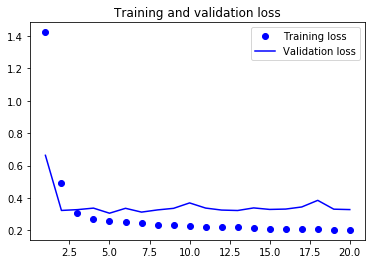

In [40]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

기본 상식모델보다, 성능이 좋지 않다. 모델이, 상당히 고차원적인 가상공간을 만들어서 패턴을 찾으려고 하나, 찾지 못한 경우라 할수 있다.  
뜻밖에도, 이는 머신러닝이 가진 제약이라고도 할수 있다.  
이 네트워크는 이미 매우 복잡하다. 복잡한 모델 공간에서 해결책을 탐색할 때 간단하고 괜찮은 성능을 내는 모델은 찾지 못할 수 있다.  
심지어 기술적으로 봤을 때 이 가설 공간에 포함되어 있을 때 조차도 말이죠. 이것이 일반적으로 머신 러닝이 가진 심각한 제약 사항이다.  
학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간단한 해결책을 찾지 못할 수 있습니다.

## 첫 번째 순환 신경망

첫 번째 완전 연결 네트워크는 잘 작동하지 않았습니다. 그렇다고 이 문제에 머신 러닝이 적합하지 않다는 뜻은 아니다.  
앞선 모델은 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸다. 대신 인과 관계와 순서가 의미가 있는 시퀀스 데이터 그대로 사용해 보면 달라진다.  
순환 시퀀스 처리 모델은 앞선 모델과 달리 데이터 포인터의 시간 순서를 사용한다.

이전 절에서 소개한 `LSTM` 층 대신에 2014년에 정준영 등이 개발한 `GRU` 층을 사용한다.  
GRU 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 그래서 계산 비용이 덜 든다.  (LSTM 만큼 표현 학습 능력이 높지는 않을 수 있습니다).  

**LSTM 활용 당시 구문 비교 remind**

-----------------------------
model = Sequential()  
model.add(Embedding(max_features, 32))  
`model.add(LSTM(32))`
-----------------------------

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 109s 219ms/step - loss: 0.3072 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2878 - val_loss: 0.2662
Epoch 3/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2810 - val_loss: 0.2681
Epoch 4/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2762 - val_loss: 0.2658
Epoch 5/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2709 - val_loss: 0.2635
Epoch 6/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2667 - val_loss: 0.2639
Epoch 7/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2602 - val_loss: 0.2644
Epoch 8/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2570 - val_loss: 0.2690
Epoch 9/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2515 - val_loss: 0.2736
Epoch 10/20
500/500 [==============================] - 109s 218m

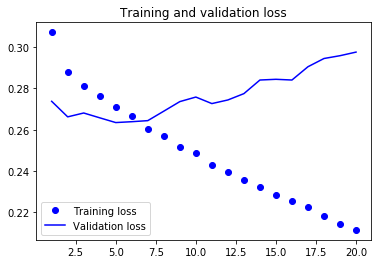

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

훈련 손실과 검증 손실 곡선을 보면 모델이 과대적합인지 알 수 있습니다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어지기 시작합니다. 이런 현상을 해결하기 위해 잘 알려진 드롭아웃 기법을 이미 보았습니다. 훈련 데이터를 층에 주입할 때 데이터에 있는 우연한 상관 관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법입니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려졌습니다. 2015년 야린 갈이 베이지안 딥러닝에 관한 박사 논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아 내었습니다. 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용해야 합니다. GRU이나 LSTM 같은 순환 게이트에 의해 만들어지는 표현을 규제하려면 순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다(순환 드롭 아웃 마스크). 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면 네트워크가 학습 오차를 타임스템에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

야린 갈은 케라스를 사용해 연구를 하였고 케라스 순환 층에 이 기능을 구현하는 데 도움을 주었습니다. 케라스에 있는 모든 순환 층은 두 개의 드롭아웃 매개변수를 가지고 있습니다. `dropout`은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값입니다. `recurrent_dropout`은 순환 상태의 드롭아웃 비율을 정합니다. GRU 층에 드롭아웃과 순환 드롭아웃을 적용해 과대적합에 어떤 영향을 미치는지 살펴보겠습니다. 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는 데 더 오래 걸립니다. 에포크를 두 배 더 늘려 네트워크를 훈련하겠습니다.

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 124s 248ms/step - loss: 0.3395 - val_loss: 0.2812
Epoch 2/40
500/500 [==============================] - 123s 247ms/step - loss: 0.3138 - val_loss: 0.2721
Epoch 3/40
500/500 [==============================] - 123s 247ms/step - loss: 0.3080 - val_loss: 0.2682
Epoch 4/40
500/500 [==============================] - 123s 247ms/step - loss: 0.3045 - val_loss: 0.2670
Epoch 5/40
500/500 [==============================] - 123s 247ms/step - loss: 0.3012 - val_loss: 0.2713
Epoch 6/40
500/500 [==============================] - 123s 247ms/step - loss: 0.3007 - val_loss: 0.2689
Epoch 7/40
500/500 [==============================] - 123s 247ms/step - loss: 0.2968 - val_loss: 0.2657
Epoch 8/40
500/500 [==============================] - 123s 247ms/step - loss: 0.2953 - val_loss: 0.2677
Epoch 9/40
500/500 [==============================] - 123s 247ms/step - loss: 0.2909 - val_loss: 0.2628
Epoch 10/40
500/500 [==============================] - 123s 247m

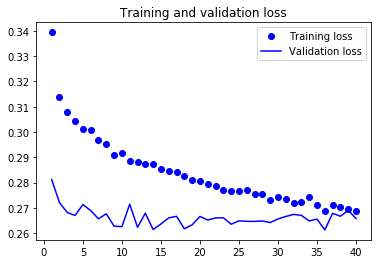

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 스태킹 순환 층

과대적합은 더 이상 없지만 성능상의 병목이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다. 일반적인 머신 러닝 작업 흐름을 기억하세요. (드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거쳤다고 가정하고) 과대적합이 일어날 때까지 네트워크의 용량을 늘리는 것이 좋습니다. 너무 많이 과대적합되지 않는 한 아직 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법입니다. 예를 들어 구글 번역 알고리즘의 현재 성능은 7개의 대규모 LSTM 층을 쌓은 대규모 모델에서 나온 것입니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간 층은 마지막 타임스텝 출력만이 아니고 전체 시퀀스(3D 텐서)를 출력해야 합니다. `return_sequences=True`로 지정하면 됩니다: 

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 250s 499ms/step - loss: 0.3360 - val_loss: 0.2779
Epoch 2/40
500/500 [==============================] - 248s 497ms/step - loss: 0.3140 - val_loss: 0.2765
Epoch 3/40
500/500 [==============================] - 248s 497ms/step - loss: 0.3067 - val_loss: 0.2697
Epoch 4/40
500/500 [==============================] - 248s 497ms/step - loss: 0.3032 - val_loss: 0.2728
Epoch 5/40
500/500 [==============================] - 248s 497ms/step - loss: 0.2981 - val_loss: 0.2650
Epoch 6/40
500/500 [==============================] - 248s 497ms/step - loss: 0.2964 - val_loss: 0.2705
Epoch 7/40
500/500 [==============================] - 249s 497ms/step - loss: 0.2911 - val_loss: 0.2655
Epoch 8/40
500/500 [==============================] - 249s 497ms/step - loss: 0.2896 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 249s 498ms/step - loss: 0.2866 - val_loss: 0.2664
Epoch 10/40
500/500 [==============================] - 249s 497m

결과를 확인해 보죠:

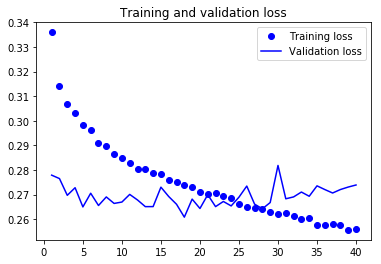

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 여기서 두 가지 결론을 얻을 수 있습니다:

* 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
* 층을 추가한 만큼 도움이 되지 않았으므로 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

## 양방향 RNN 사용하기

이 절에서 소개할 마지막 기법은 양방향 RNN입니다. 양방향 RNN은 RNN의 한 변종이고 특정 작업에서 기본 RNN 보다 훨씬 좋은 성능을 냅니다. 자연어 처리에서는 맥가이버 칼이라고 할 정도로 즐겨 사용됩니다.

RNN은 특히 순서 또는 시간에 민감합니다. 즉, 입력 시퀀스의 타입스텝 순서대로 처리합니다. 타입스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다. 이는 온도 예측과 같이 순서에 의미가 있는 문제에 잘 맞는 이유이기도 합니다. 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM 같은 RNN 두 개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향(시간의 순서나 반대 순서)으로 처리한 다음 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

놀랍게도 이 절에 있는 RNN 층이 시간의 순서대로 (오래된 타임스텝이 먼저 나오도록) 시퀀스를 처리하는 것은 근거 없는 결정입니다. 적어도 이 결정을 궁금해하지 않았습니다. 시간의 반대 방향으로 (최근 타임스텝이 먼저 나오도록) 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제 이렇게 해 보고 결과가 어떤지 확인해 보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다:

In [20]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [21]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 112s 224ms/step - loss: 0.4750 - val_loss: 0.4889
Epoch 2/20
500/500 [==============================] - 111s 223ms/step - loss: 0.4524 - val_loss: 0.4769
Epoch 3/20
500/500 [==============================] - 111s 223ms/step - loss: 0.4186 - val_loss: 0.4593
Epoch 4/20
500/500 [==============================] - 111s 223ms/step - loss: 0.3778 - val_loss: 0.4280
Epoch 5/20
500/500 [==============================] - 111s 223ms/step - loss: 0.3553 - val_loss: 0.4672
Epoch 6/20
500/500 [==============================] - 111s 223ms/step - loss: 0.3386 - val_loss: 0.4349
Epoch 7/20
500/500 [==============================] - 111s 223ms/step - loss: 0.3224 - val_loss: 0.4291
Epoch 8/20
500/500 [==============================] - 111s 223ms/step - loss: 0.3109 - val_loss: 0.4187
Epoch 9/20
500/500 [==============================] - 111s 223ms/step - loss: 0.2995 - val_loss: 0.4242
Epoch 10/20
500/500 [==============================] - 111s 223m

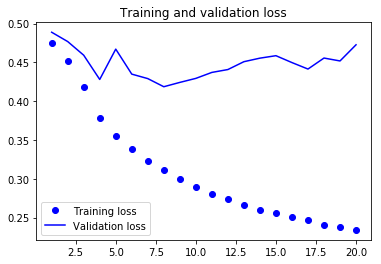

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 사실 이는 당연합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다. 또한, 최근에 가까운 날씨 데이터 포인트일수록 오래된 데이터 포인트보다 예측에 유용합니다(상식 수준의 기준점이 꽤 강력한 이유입니다). 시간 순서대로 처리하는 네트워크가 거꾸로 처리하는 것보다 성능이 높아야만 합니다. 하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 같은 기법을 이전 절의 LSTM IMDB 예제에 적용해 보죠:

In [23]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.4841 - acc: 0.7701 - val_loss: 0.3777 - val_acc: 0.8588
Epoch 2/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.3136 - acc: 0.8791 - val_loss: 0.6957 - val_acc: 0.7904
Epoch 3/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2685 - acc: 0.9016 - val_loss: 0.3353 - val_acc: 0.8630
Epoch 4/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2195 - acc: 0.9195 - val_loss: 0.5092 - val_acc: 0.8182
Epoch 5/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1973 - acc: 0.9317 - val_loss: 0.3785 - val_acc: 0.8692
Epoch 6/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1733 - acc: 0.9383 - val_loss: 0.3698 - val_acc: 0.8780
Epoch 7/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1595 - acc: 0.9451 - val_loss: 0.4101 - val_acc:

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터셋에는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 잘 작동합니다. 이는 언어를 이해하는 데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침합니다. 거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 다른 표현을 학습합니다. 이와 비슷하게 시작할 때 죽고 마지막 날 태어나는 삶처럼 실제 세상의 시간이 거꾸로 흘러간다면 우리의 정신 세계가 달라질 것입니다. 머신 러닝에서 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 이 표현이 많이 다를수록 더 좋습니다. 이 표현이 데이터를 바라보는 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이런 표현은 작업의 성능을 올리는 데 도움을 줍니다. 이것이 다음 장에서 살펴볼 앙상블의 개념입니다.

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시퀀스를 양쪽 방향으로 바라보기 때문에, 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할 때 놓칠 수 있는 패턴을 잡아 냅니다.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

케라스에서는 `Bidirectional` 층을 사용하여 양방향 RNN을 만듭니다. 이 클래스는 첫 번째 매개변수로 순환 층의 객체를 전달받습니다. `Bidirectional` 클래스는 전달받은 순환 층으로 새로운 두 번째 객체를 만듭니다. 하나는 시간 순서대로 입력 시퀀스를 처리하고 다른 하나는 반대 순서로 입력 시퀀스를 처리합니다. IMDB 감성 분석 문제에 이를 적용해 보죠:

In [24]:
from keras import backend as K
K.clear_session()

In [25]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 137s 7ms/step - loss: 0.5601 - acc: 0.7167 - val_loss: 0.3782 - val_acc: 0.8538
Epoch 2/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.3297 - acc: 0.8728 - val_loss: 0.4579 - val_acc: 0.8104
Epoch 3/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2649 - acc: 0.9032 - val_loss: 0.5085 - val_acc: 0.8412
Epoch 4/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2348 - acc: 0.9154 - val_loss: 0.3106 - val_acc: 0.8798
Epoch 5/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2058 - acc: 0.9269 - val_loss: 0.3287 - val_acc: 0.8838
Epoch 6/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.1828 - acc: 0.9372 - val_loss: 0.3816 - val_acc: 0.8766
Epoch 7/10
20000/20000 [==============================] - 137s 7ms/step - loss: 0.1686 - acc: 0.9405 - val_loss: 0.3666 - v

여기서 얻은 검증 정확도는 88% 정도로 이전 절에서 사용했던 일반 LSTM보다 조금 더 성능이 높습니다. 이 모델은 조금 더 일찍 과대적합되는 것 같습니다. 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문에 놀라운 일은 아닙니다. 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합해 보입니다.

이제 동일한 방식을 온도 예측 문제에 적용해 보죠:

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 205s 411ms/step - loss: 0.2930 - val_loss: 0.2739
Epoch 2/40
500/500 [==============================] - 205s 409ms/step - loss: 0.2743 - val_loss: 0.2716
Epoch 3/40
500/500 [==============================] - 205s 409ms/step - loss: 0.2666 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 204s 409ms/step - loss: 0.2628 - val_loss: 0.2705
Epoch 5/40
500/500 [==============================] - 204s 409ms/step - loss: 0.2553 - val_loss: 0.2730
Epoch 6/40
500/500 [==============================] - 205s 410ms/step - loss: 0.2488 - val_loss: 0.2715
Epoch 7/40
500/500 [==============================] - 205s 409ms/step - loss: 0.2448 - val_loss: 0.2799
Epoch 8/40
500/500 [==============================] - 205s 410ms/step - loss: 0.2399 - val_loss: 0.2820
Epoch 9/40
500/500 [==============================] - 205s 410ms/step - loss: 0.2334 - val_loss: 0.2822
Epoch 10/40
500/500 [==============================] - 205s 409m

이 네트워크는 일반 GRU 층과 비슷한 성능을 냅니다. 이유는 쉽게 이해할 수 있습니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 때문입니다(최근의 정보가 오래 전의 정보보다 훨씬 더 중요합니다).